In [2]:
import numpy as np
import pandas as pd
import bisection
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy import special as sp

**EM Algorithm implementation for 2-modes gaussian mixture**

$ P(y) = p*N(y, 0, 1) + (1-p)*N(y, 0, 1+\tau^2)$

$ log\_like = \sum_{i = 0} ^ N \log \left( \sum_{k=1}^2 P_k N(y_i, 0, \sigma_k) \right)$

$\theta$ = (p, $\tau^2$)

In [3]:
#Gaussian with mu=0
def N(y_s, sigma2):
    return 1/np.sqrt(2*np.pi*sigma2) * np.exp(- y_s**2/(2*sigma2))

def P_k(ys, p, tau2, k): #returns the values of P_k for any i, based on current theta, corresponds to the E-step
    if k==1:
        Ps = p*N(ys, 1) #N-shaped array
    else:
        Ps = (1-p)*N(ys, 1+tau2)
    Ss = np.sum([p*N(ys, 1), (1-p)*N(ys, 1+tau2)], axis=0) #N-shaped array
    return Ps/Ss

def get_Q(theta, ys, theta_t):
    Q_i_k_s = np.array([P_k(ys, theta_t[0], theta_t[1], 1)*theta[0]*N(ys, 1),
                        P_k(ys, theta_t[0], theta_t[1], 2)*(1-theta[0])*N(ys, 1+theta[1])]) #2xN matrix
    Q_i_s = np.log(np.sum(Q_i_k_s, axis=0)) #N-shaped array
    Q = np.sum(Q_i_s)
    return Q

#Da qui in giù è da sistemare
def theta_est(ys, theta_t): #returns estimates of p_k and sigma2_k, corresponds to the M-step
    P_1_s = P_k(ys, theta_t[0], theta_t[1], 1) #k=1, we use this for estimating p since sigma2 = 1 for that mode
    N_1_k = np.sum(P_1_s)
    p = N_1_k/len(ys)
    
    P_2_s = P_k(ys, theta_t[0], theta_t[1], 2) #k=2, we use this for estimating sigma2 since P_2 = 1-p for that mode
    N_2_k = np.sum(P_2_s)
    tau2 = np.sum(P_2_s * ys**2)/N_2_k - 1 #sigma^2 - 1 = tau^2
    
    return [p, tau2]

def EM_alg (ys, theta_now):
    theta_next = np.array(theta_est(ys, theta_now))
    Q = get_Q(theta_next, ys, theta_now)
    return theta_next, Q

def EM_run (ys, theta_init, prnt = True):
    Qs = []
    theta_now, Q = EM_alg(ys, theta_init)
    Qs.append(Q)
    i, deltaQ = 0, 1
    while deltaQ >0.0001:
        i += 1
        theta_next, Q = EM_alg(ys, theta_now)
        Qs.append(Q)
        deltaQ = Qs[i]-Qs[i-1]
        theta_now = theta_next
    if prnt:
        print('Convergence reached: p = %.3f'%theta_now[0]+ '\t tau^2'+' = %.3f'%theta_now[1])
    return theta_now, Qs

In [4]:
DF = pd.read_csv('sparsedatawitherrors.ascii', sep = '\t', names = ['GT', 'y'])
GTs = np.array(DF['GT'])
y_dat_s = np.array(DF['y'])
theta_init = np.array([0.5, 10])
theta, Qs = EM_run (y_dat_s, theta_init)
p_hat, tau2_hat = theta[0], theta[1] 

Convergence reached: p = 0.946	 tau^2 = 75.006


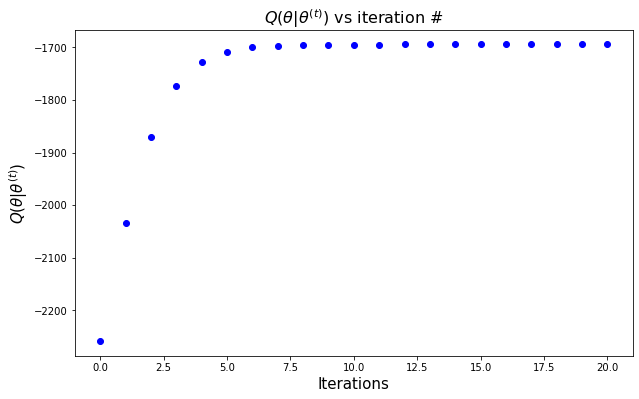

In [5]:
plt.figure(figsize=(10,6))
plt.plot(range(len(Qs)), Qs, 'bo')
plt.xlabel("Iterations", size=15)
plt.ylabel(r"$Q(\theta | \theta^{(t)})$", size = 15)
plt.title(r"$Q(\theta | \theta^{(t)})$"+" vs iteration #", size = 16)
plt.savefig('Qs.pdf')

**BOOTSTRAPPING**

In [6]:
#creates a randomized (with replacement) version of the data sample
def resample(ys):
    ys_new = np.random.choice(ys, size = len(ys))
    return ys_new

#returns an array with the parameters estimated at every 
def bootstrap(y_dat_s, theta_init, B = 1000):
    theta_s = []
    theta, _ = EM_run (y_dat_s, theta_init, prnt = False)
    theta_s.append(theta)
    for i in range(B):
        y_res_s = resample(y_dat_s)
        theta, _ = EM_run (y_res_s, theta_init, prnt = False)
        theta_s.append(theta)
    return np.array(theta_s)

In [7]:
theta_s = bootstrap(y_dat_s, theta_init)
print(np.std(theta_s[:,0]))
print(np.std(theta_s[:,1]))

0.008657750475052708
13.671127362424398


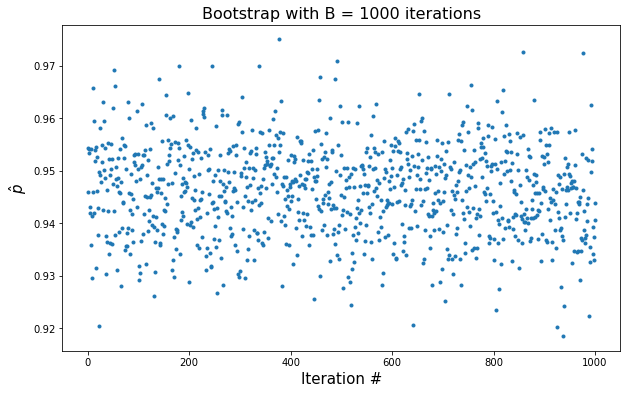

In [8]:
plt.figure(figsize=(10,6))
plt.plot(range(len(theta_s[:,0])), theta_s[:,0], '.')
plt.xlabel("Iteration #", size=15)
plt.ylabel(r'$\hat p$', size = 15)
plt.title("Bootstrap with B = 1000 iterations", size = 16)
plt.savefig('Bootstrap_p.pdf')

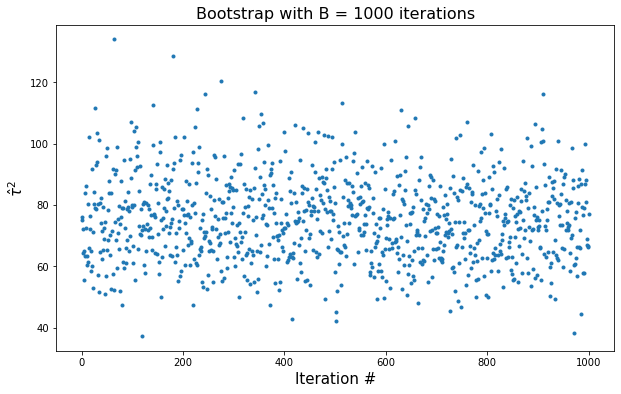

In [9]:
plt.figure(figsize=(10,6))
plt.plot(range(len(theta_s[:,1])), theta_s[:,1], '.')
plt.xlabel("Iteration #", size=15)
plt.ylabel(r'$\hat\tau^2$', size = 15)
plt.title("Bootstrap with B = 1000 iterations", size = 16)
plt.savefig('Bootstrap_tau.pdf')

**OBSERVED INFORMATION MATRIX**

Our Log-Likelihood is:

$l(y|p, \tau^2) = \sum_N \log mix(y_i, p, \tau^2)$

In [10]:
#Works for both an integer y_i or an array y_s
def mix (y, p, tau2):
    return p*N(y, 1) + (1-p)*N(y, 1 + tau2)

def log_L (y, p, tau2):
    logs = np.log(mix(y, p, tau2))
    return np.sum(logs)

def L (y, p, tau2):
    return sp.logsumexp(mix(y, p, tau2))

#derivative of logL wrt p
def dl_dp (y, p, tau2):
    dls= (N(y, 1) - N(y, 1 + tau2))/mix(y, p, tau2)
    return np.sum(dls)

#derivative of logL wrt tau2
def dl_dtau2 (y, p, tau2):
    dls= ((1-p)*N(y, 1 + tau2)/(1+tau2)*(y**2/(2*(1+tau2)) -2))/mix(y, p, tau2)
    return np.sum(dls)

#Now I compute numerically the second derivatives to obtain the hessian of the likelihood = observed information matrix
#I have to define 4 different functions since the first argument must be the parameter we are changing during the derivation
def fp_p (p, y, tau2):
    return dl_dp (y, p, tau2)

def fp_tau2 (tau2, y, p):
    return dl_dp (y, p, tau2)

def ftau2_p (p, y, tau2):
    return dl_dtau2 (y, p, tau2)

def ftau2_tau2 (tau2, y, p):
    return dl_dtau2 (y, p, tau2)

def derivative(f, a, par1, par2, method='central', h=0.00001):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    par1, par2 : parameter
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula         
    '''
    if method == 'central':
        return (f(a + h, par1, par2) - f(a - h, par1, par2))/(2*h)
    elif method == 'forward':
        return (f(a + h, par1, par2) - f(a, par1, par2))/h
    elif method == 'backward':
        return (f(a, par1, par2) - f(a - h, par1, par2))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")

In [11]:
#we compute the observed info matrix
O_I = np.array([[derivative(fp_p, p_hat, y_dat_s, tau2_hat), derivative(fp_tau2, tau2_hat, y_dat_s, p_hat)],
              [derivative(ftau2_p, p_hat, y_dat_s, tau2_hat), derivative(ftau2_tau2, tau2_hat, y_dat_s, p_hat)]])
O_I

array([[-1.37516912e+04,  1.86143397e+00],
       [ 7.73381810e+00,  1.18197698e-02]])

In [12]:
Cov = np.linalg.inv(O_I)
Cov
Cor = np.sqrt(np.abs(Cov))
Cor

array([[8.17323860e-03, 1.02568378e-01],
       [2.09067557e-01, 8.81592172e+00]])

**LIKELIHOOD CONTOURS**

In [13]:
n_p, n_tau2 = (100, 1000)
ps = np.linspace(0.8, 1, n_p)
tau2s = np.linspace(50, 130, n_tau2)
ps_2d, tau2s_2d = np.meshgrid(ps, tau2s) #necessary for creating 2D arrays to pass to contour()
Ls_s = []
for tau2 in tau2s:
    Ls = []
    for p in ps:
        Ls.append(log_L(y_dat_s, p, tau2))
    Ls_s.append(Ls)
Ls_s = np.array(Ls_s)

In [14]:
L_max = np.max(Ls_s, axis=(0,1))
ind_max = np.unravel_index(np.argmax(Ls_s, axis=None), Ls_s.shape) #argmax of a 2D array
p_max, tau2_max = ps[ind_max[1]], tau2s[ind_max[0]]
print('ML - estimate of the parameters: p = %.3f'%p_max +', tau2 = %.3f'%tau2_max)

ML - estimate of the parameters: p = 0.945, tau2 = 74.745


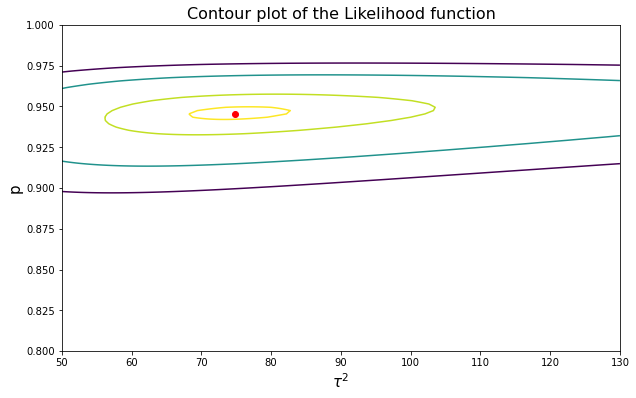

In [15]:
plt.figure(figsize=(10,6))
plt.contour(tau2s_2d, ps_2d, Ls_s, levels = [L_max - 10, L_max - 5, L_max - 1, L_max - 0.1])
plt.plot(tau2_max, p_max, 'bo', color='r')
plt.xlabel(r'$\tau^2$', size=15)
plt.ylabel('p', size = 15)
plt.title("Contour plot of the Likelihood function", size = 16)
plt.savefig('Contour.pdf')